## Applying Natural language processing techniques for classifying a message (tweet) as positive (happy), neutral or negative sentiment using Python

The data is taken from https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset?select=train.csv \
Steps in the data analysis: \
(1) Import relevanlt libraries \
(2) Feature engineering \
(3) Text preprocessing using "stopwords" from NLTK corpus library \
(4) Use CountVectorizer to construct a 2d-matrix from text messages
(5) Building model \
(6) Evaluating a model using confusion matrix


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import os
import pickle
#os.system('jupyter nbconvert --clear-output --inplace NLP_Sentiment.ipynb')
#os.system("jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10")



In [2]:
# Download the training data and test data from Kaggle
# Read this page to learn how to download data from Kaggle
# https://www.geeksforgeeks.org/how-to-download-kaggle-datasets-into-jupyter-notebook
#Alternnatively, you can use the code below to directly download the data
#using your kaggle username and kaggle api key

import opendatasets as od
import os
od.download("https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset?select=train.csv")           
os.listdir('.')
os.system('rm sentiment-analysis-dataset/test.csv')
os.system('rm sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv')
os.system('rm sentiment-analysis-dataset/testdata.manual.2009.06.14.csv')
os.system('mv  sentiment-analysis-dataset/train.csv sentiment-analysis-dataset/data.csv')

os.listdir('sentiment-analysis-dataset')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: amitkr2410
Your Kaggle Key: ········


100%|██████████████████████████████████████| 54.4M/54.4M [00:09<00:00, 6.00MB/s]


['data.csv']

In [39]:
# read file into pandas using a relative path
df = pd.read_csv("sentiment-analysis-dataset/data.csv", encoding='latin-1')
df = df.loc[:,['text', 'sentiment']]
df.dropna(how="any", inplace=True, axis=0)
df.columns = ['message', 'label']
df.loc[len(df)+1] = {'message': 'no', 'label': 'negative'}
df.loc[len(df)+1] = {'message': 'not', 'label': 'negative'}

print(df.iloc[0:20,:])
print(df.shape)

                                              message     label
0                 I`d have responded, if I were going   neutral
1       Sooo SAD I will miss you here in San Diego!!!  negative
2                           my boss is bullying me...  negative
3                      what interview! leave me alone  negative
4    Sons of ****, why couldn`t they put them on t...  negative
5   http://www.dothebouncy.com/smf - some shameles...   neutral
6   2am feedings for the baby are fun when he is a...  positive
7                                          Soooo high   neutral
8                                         Both of you   neutral
9    Journey!? Wow... u just became cooler.  hehe....  positive
10   as much as i love to be hopeful, i reckon the...   neutral
11  I really really like the song Love Story by Ta...  positive
12       My Sharpie is running DANGERously low on ink  negative
13  i want to go to music tonight but i lost my vo...  negative
14                         test test fro

In [40]:
#df.head()
df

,message,label
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive
27480,All this flirting going on - The ATG smiles...,neutral
27481,no,negative


In [41]:
df.isnull().sum()

message    0
label      0
dtype: int64

In [42]:
print(df['label'].value_counts())
print(df['label'].value_counts().index )

neutral     11117
positive     8582
negative     7783
Name: label, dtype: int64
Index(['neutral', 'positive', 'negative'], dtype='object')


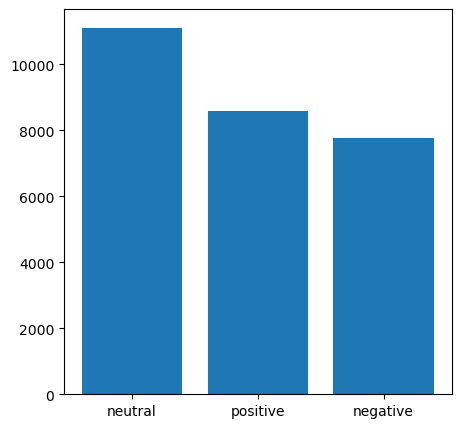

In [43]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.bar( df['label'].value_counts().index, df['label'].value_counts() )
plt.show() 


In [44]:
# convert label to a numerical variable
df['label_num'] = df.label.map({'neutral':0, 'positive':1, 'negative':-1 })
df.head()

,message,label,label_num
0,"I`d have responded, if I were going",neutral,0
1,Sooo SAD I will miss you here in San Diego!!!,negative,-1
2,my boss is bullying me...,negative,-1
3,what interview! leave me alone,negative,-1
4,"Sons of ****, why couldn`t they put them on t...",negative,-1


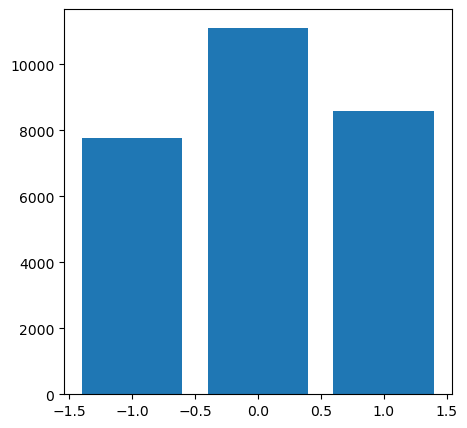

In [45]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.bar( df['label_num'].value_counts().index, df['label_num'].value_counts() )
plt.show() 

In [46]:
#df['message_len'] = df['message'].apply(len)
df['message_word_count'] = df['message'].apply(lambda x: len(x.split(' ')) )

print(df.iloc[1,1])
print(df.head())
print(df.describe())
df.head()

negative
                                             message     label  label_num  \
0                I`d have responded, if I were going   neutral          0   
1      Sooo SAD I will miss you here in San Diego!!!  negative         -1   
2                          my boss is bullying me...  negative         -1   
3                     what interview! leave me alone  negative         -1   
4   Sons of ****, why couldn`t they put them on t...  negative         -1   

   message_word_count  
0                   8  
1                  11  
2                   5  
3                   6  
4                  15  
          label_num  message_word_count
count  27482.000000        27482.000000
mean       0.029074           13.778983
std        0.771140            7.170258
min       -1.000000            1.000000
25%       -1.000000            8.000000
50%        0.000000           13.000000
75%        1.000000           19.000000
max        1.000000          101.000000


,message,label,label_num,message_word_count
0,"I`d have responded, if I were going",neutral,0,8
1,Sooo SAD I will miss you here in San Diego!!!,negative,-1,11
2,my boss is bullying me...,negative,-1,5
3,what interview! leave me alone,negative,-1,6
4,"Sons of ****, why couldn`t they put them on t...",negative,-1,15


Text(0.5, 0, 'Message Word count')

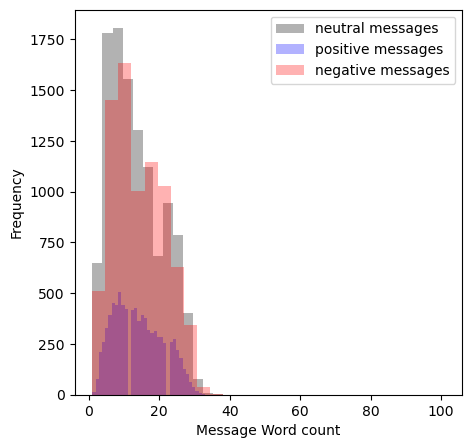

In [47]:
plt.figure(figsize=(5, 5))

df[df.label=='neutral'].message_word_count.plot(bins=35, kind='hist', color='black', 
                                       label='neutral messages', alpha=0.3)
df[df.label=='positive'].message_word_count.plot(bins=35, kind='hist', color='blue', 
                                       label='positive messages', alpha=0.3)
df[df.label=='negative'].message_word_count.plot(kind='hist', color='red', 
                                       label='negative messages', alpha=0.3)


plt.legend()
plt.xlabel("Message Word count")

#Since the number of feature vector would depend on number of words in each row

In [48]:
# Text Pre-processing using "stopwords" from NLTK corpus library
#Tokenization is a term used to describe the normal text strings into a list of tokens or base words
# As a first step, let's write a function that will split a message into its individual words 
# and return a list. We'll also remove very common words, ('the', 'a', etc..). 
# To do this we will take advantage of the NLTK library. It's pretty much the standard library 
# in Python for processing text and has a lot of useful features. 
# We'll only use some of the basic ones here.
#We will also remove prefix and suffix using PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def text_process(message):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords using nltk stopwords
    3. Remove prefix and suffix using PorterStemmer
    4. Returns a list of the cleaned text
    """
    newstring_list = []
    newstring = ""
    ans = newstring
    # Check characters to see if they are in punctuation or numbers
    for j in message:
        if j.isalpha():
            newstring_list.append(j)
        elif j in string.punctuation:
            newstring_list.append(" ") 
        else:
            newstring_list.append(" ")
    # Join the characters again to form the string.        
    newstring = "".join(newstring_list)
    #print(newstring)
    ans = newstring
    newstring = ""
    
    #We'll  remove very common words, ('the', 'a', etc..) using stopwords
    STOPWORDS = stopwords.words('english') + ['http', 'www', '', 'u', 'ü', 'ur', '4', '2', 'im', 'doin', 'ure']
    ps = PorterStemmer()
    CustomWord = ['not', 'no', 'against' ]
    
    for word in ans.split(): 
        #print(word, len(word))
        if (word.lower() not in STOPWORDS) and  ( len(word)!=1):
            if (len(ps.stem(word)) < 15):
                newstring = newstring + str( ps.stem(word) + " ")
        if word in CustomWord:
            newstring = newstring + str( ps.stem(word) + " ")
    ans = newstring
    newstring = ""
    #print(ans)
    
    return ans

word='amit not no  h http2 @man mynameisamitwhatis geomorphologically '
ans = text_process(word)
print(ans)

amit not no man geomorpholog 


In [49]:
df['base_message'] = df.message.apply(text_process)
print(df.shape)
df.head()

(27482, 5)


,message,label,label_num,message_word_count,base_message
0,"I`d have responded, if I were going",neutral,0,8,respond go
1,Sooo SAD I will miss you here in San Diego!!!,negative,-1,11,sooo sad miss san diego
2,my boss is bullying me...,negative,-1,5,boss bulli
3,what interview! leave me alone,negative,-1,6,interview leav alon
4,"Sons of ****, why couldn`t they put them on t...",negative,-1,15,son put releas alreadi bought


In [50]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split

# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = df.base_message
y = df.label_num
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

##For xGBoost and NaiveBayes
#''' 
y_train_xGBoost = y_train.copy()
y_test_xGBoost = y_test.copy()
for i in range(len(y_train)):
    if y_train.iloc[i] ==-1:
        y_train_xGBoost.iloc[i] = 2
        
for i in range(len(y_test)):
    if y_test.iloc[i] ==-1:
        y_test_xGBoost.iloc[i] = 2
#''' 
###
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(len(y_test))
print(y_train.value_counts())
print(y_train_xGBoost.value_counts())
print(y_test.value_counts())
print(y_test_xGBoost.value_counts())
X_train.iloc[0]

(27482,)
(27482,)
(20611,)
(20611,)
(6871,)
6871
 0    8326
 1    6457
-1    5828
Name: label_num, dtype: int64
0    8326
1    6457
2    5828
Name: label_num, dtype: int64
 0    2791
 1    2125
-1    1955
Name: label_num, dtype: int64
0    2791
1    2125
2    1955
Name: label_num, dtype: int64


'last night bottl wine hous cocktail came home sober still gonna sick '

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
cv = CountVectorizer()
x_fit = cv.fit(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = cv.transform(X_train)

# equivalently: combine fit and transform into a single step
#X_train_dtm = cv.fit_transform(X_train)


# examine the document-term matrix
#print(type(X_train_dtm), X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = cv.transform(X_test)

#print( X_train_dtm[0][0] )
print(list(x_fit.vocabulary_.items())[0:10])
print(x_fit.get_feature_names_out())

#Save the featuring function CountVectorizer
pickle.dump(cv, open('../preprocess/CountVectorizer.pickle','wb') )

[('last', 8007), ('night', 9776), ('bottl', 1685), ('wine', 15861), ('hous', 6621), ('cocktail', 2751), ('came', 2114), ('home', 6528), ('sober', 13065), ('still', 13491)]
['aa' 'aaa' 'aaaa' ... 'zywwj' 'zzzz' 'zzzzi']


In [52]:
print( len(x_fit.get_feature_names_out()) )
cv.get_feature_names_out()[1000:1020]

16499


array(['baggag', 'baggin', 'baguio', 'bah', 'baha', 'bahah', 'bahaha',
       'bahahah', 'bahahaha', 'bahama', 'bahhhh', 'bahrain', 'bai',
       'bail', 'baildon', 'bailey', 'baillon', 'bailon', 'bait',
       'baitersss'], dtype=object)

In [53]:
#2d matrix, each row is one message, column's are tokenize vector
X_train_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [54]:
# Visulaization of matrix examine the vocabulary and document-term matrix together
df_ans = pd.DataFrame(X_train_dtm.toarray(), columns=cv.get_feature_names())
df_ans

/Users/amitkumar/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaa,aaaa,aaaaaaaaaamaz,aaaaaah,aaaaaahhhhhhhh,aaaaaawwwesom,aaaaahhhh,aaaaall,aaaaawhh,...,zv,zw,zwd,zwitschert,zy,zyg,zyrtec,zywwj,zzzz,zzzzi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20606,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Visulaization of matrix examine the vocabulary and document-term matrix together
df_ans2 = pd.DataFrame(X_train_dtm.toarray(), columns=cv.get_feature_names())
df_ans2.iloc[:,1000:1020]

/Users/amitkumar/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,baggag,baggin,baguio,bah,baha,bahah,bahaha,bahahah,bahahaha,bahama,bahhhh,bahrain,bai,bail,baildon,bailey,baillon,bailon,bait,baitersss
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20606,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20607,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20608,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20609,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model for classification
(1) Logistic Regression \
(2) Decision Tree \
(3) Random Forest \
(4) Support Vector Classifier \
(5) Xtreme Gradient Boosting (xGBoost)\
(6) NaiveBayes

In [56]:
'''
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
'''
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

In [57]:
#define a function to plot 3x3 confusion matrix
def plot_confusion_matrix(cnf_mat, LabelS, cmap=plt.cm.Blues): 
    fig, ax = plt.subplots(1, 1)
    ims = ax.imshow(cnf_mat, interpolation='nearest', cmap=cmap)
    plt.colorbar(ims, ax=ax)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(LabelS))
    plt.xticks(tick_marks, LabelS, rotation=45)
    plt.yticks(tick_marks, LabelS)
    for i  in range(0,3):
        for j in range(0,3):
            plt.text(j,i,cnf_mat[i][j])

#Retrive classification report and consfusion matrix
from sklearn.metrics import classification_report, confusion_matrix
def EvaluateModel(y_test, y_predict):
    print( classification_report(y_test, y_predict) )
    cnf_mat = confusion_matrix(y_test, y_predict, labels=[-1, 0,1])
    print(cnf_mat)
    plot_confusion_matrix(cnf_mat, LabelS=['Negative(-1)','Neutral(0)','Positive(1)'])
    
#For xGBoost as y can not be negative
def EvaluateModelxGBoost(y_test, y_predict):
    print( classification_report(y_test, y_predict) )
    cnf_mat = confusion_matrix(y_test, y_predict, labels=[2, 0,1])
    print(cnf_mat)
    plot_confusion_matrix(cnf_mat, LabelS=['Negative(-1)','Neutral(0)','Positive(1)'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic Regression 
 BestScore:  0.691088182022413 
 Best parameters:  {'max_iter': 2000, 'solver': 'liblinear'}
              precision    recall  f1-score   support

          -1       0.88      0.81      0.84      5828
           0       0.83      0.87      0.85      8326
           1       0.88      0.87      0.88      6457

    accuracy                           0.86     20611
   macro avg       0.86      0.85      0.86     20611
weighted avg       0.86      0.86      0.86     20611

[[4735  887  206]
 [ 490 7281  555]
 [ 174  657 5626]]


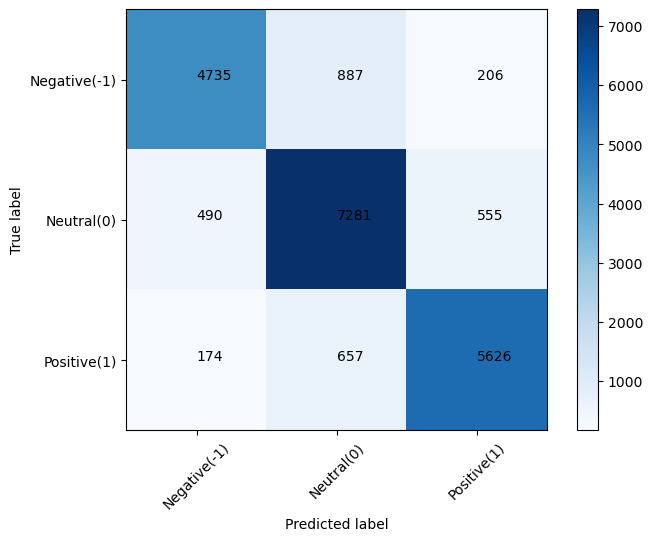

In [58]:
#Use logistic regression model to the data
from sklearn.linear_model import LogisticRegression
import numpy as np

lr = LogisticRegression()
param_grid = { 'max_iter' : [2000], 'solver' : ['liblinear']}
'''
    'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}
''' 
lr_model = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_lr = lr_model.fit(X_train_dtm, y_train)
print('Logistic Regression', "\n", 
                "BestScore: ", best_lr.best_score_, '\n',
                 "Best parameters: ", best_lr.best_params_ )


#Print confusion matrix
y_predict_lr = lr_model.predict(X_train_dtm)
EvaluateModel(y_train, y_predict_lr) 

#Model predictions
y_test_predict_lr = lr_model.predict(X_test_dtm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
DecisionTreeClassifier 
 BestScore:  0.6591623915872697 
 Best parameters:  {}
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      5828
           0       1.00      1.00      1.00      8326
           1       1.00      1.00      1.00      6457

    accuracy                           1.00     20611
   macro avg       1.00      1.00      1.00     20611
weighted avg       1.00      1.00      1.00     20611

[[5815   11    2]
 [  17 8301    8]
 [   3   19 6435]]


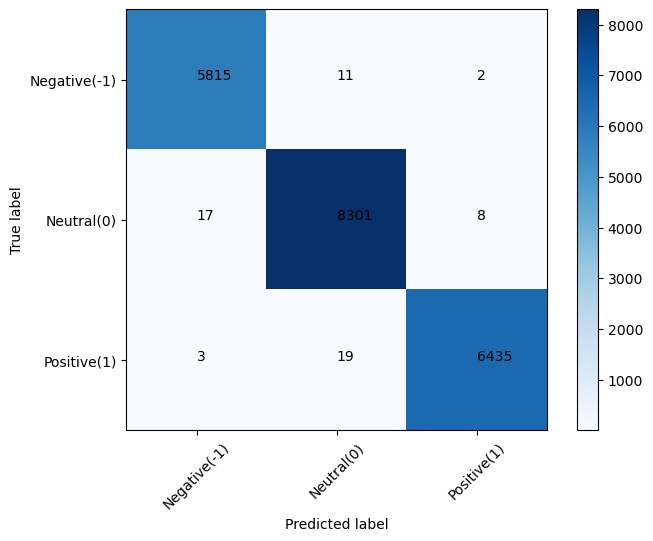

In [59]:
#Using  DecisionTree Classifier to model the data
from sklearn import tree
dct = tree.DecisionTreeClassifier()
param_grid = { } #'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
dct_model = GridSearchCV(dct, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_dct = dct_model.fit(X_train_dtm, y_train)
print('DecisionTreeClassifier', "\n", 
                "BestScore: ", best_dct.best_score_, '\n',
                 "Best parameters: ", best_dct.best_params_ )


#Print confusion matrix
y_predict_dct = dct_model.predict(X_train_dtm)
EvaluateModel(y_train, y_predict_dct) 

#Model predictions
y_test_predict_dct = dct_model.predict(X_test_dtm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
RandomForestClassifier 
 BestScore:  0.6962788951060094 
 Best parameters:  {}
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      5828
           0       1.00      1.00      1.00      8326
           1       1.00      1.00      1.00      6457

    accuracy                           1.00     20611
   macro avg       1.00      1.00      1.00     20611
weighted avg       1.00      1.00      1.00     20611

[[5804   22    2]
 [   7 8310    9]
 [   3   18 6436]]


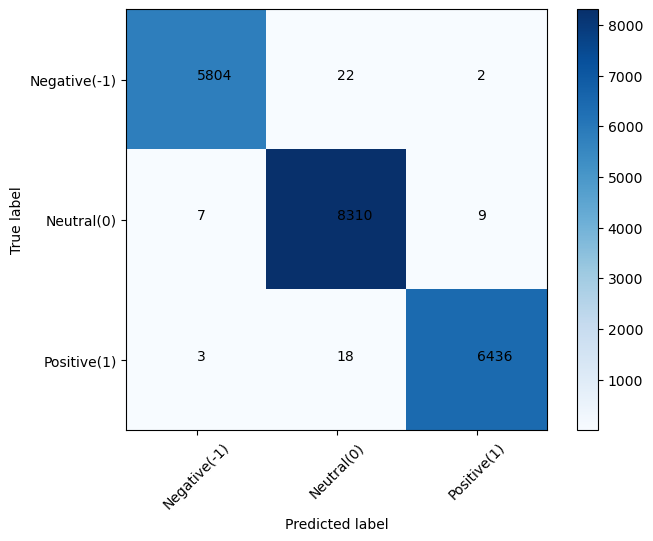

In [60]:
#Using  RandomForest  Classifier to model the data
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
param_grid = { } 
'''
                'n_estimators': [200, 400],
                'criterion':['gini','entropy'],
                'bootstrap': [True],
                'max_depth': [15],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [2],
                'min_samples_split': [2]}
                '''
rfc_model = GridSearchCV(rfc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_rfc = rfc_model.fit(X_train_dtm, y_train)
print('RandomForestClassifier', "\n", 
                "BestScore: ", best_rfc.best_score_, '\n',
                 "Best parameters: ", best_rfc.best_params_ )


#Print confusion matrix
y_predict_rfc = rfc_model.predict(X_train_dtm)
EvaluateModel(y_train, y_predict_rfc) 

#Model predictions
y_test_predict_rfc = rfc_model.predict(X_test_dtm)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
SupportVectorClassifier 
 BestScore:  0.6752706953727345 
 Best parameters:  {}
              precision    recall  f1-score   support

          -1       0.95      0.84      0.89      5828
           0       0.85      0.94      0.89      8326
           1       0.93      0.89      0.91      6457

    accuracy                           0.90     20611
   macro avg       0.91      0.89      0.90     20611
weighted avg       0.90      0.90      0.90     20611

[[4909  805  114]
 [ 185 7834  307]
 [  99  608 5750]]


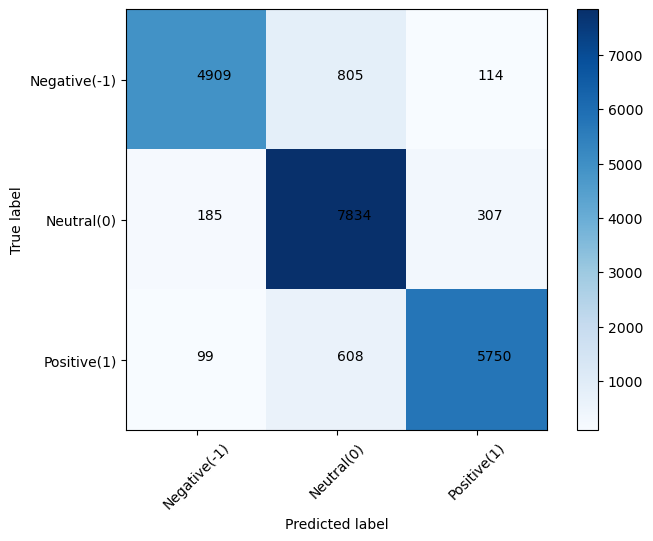

In [62]:
#Using  Support vector  Classifier to model the data
from sklearn.svm import SVC

svc = SVC(random_state=0)
param_grid = {}
''' 
    'C': [0.1, 1, 10, 100, 1000], 
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf'] }
''' 
svc_model = GridSearchCV(svc, param_grid = param_grid, cv = 2, verbose = True)
best_svc = svc_model.fit(X_train_dtm, y_train)
print('SupportVectorClassifier', "\n", 
                "BestScore: ", best_svc.best_score_, '\n',
                 "Best parameters: ", best_svc.best_params_ )


#Print confusion matrix
y_predict_svc = svc_model.predict(X_train_dtm)
EvaluateModel(y_train, y_predict_svc) 

#Model predictions
y_test_predict_svc = svc_model.predict(X_test_dtm)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
xGBoost Classifier 
 BestScore:  0.6908449433741861 
 Best parameters:  {}
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      8326
           1       0.83      0.75      0.78      6457
           2       0.83      0.60      0.69      5828

    accuracy                           0.74     20611
   macro avg       0.77      0.73      0.74     20611
weighted avg       0.76      0.74      0.74     20611

[[3471 2092  265]
 [ 552 7032  742]
 [ 162 1482 4813]]


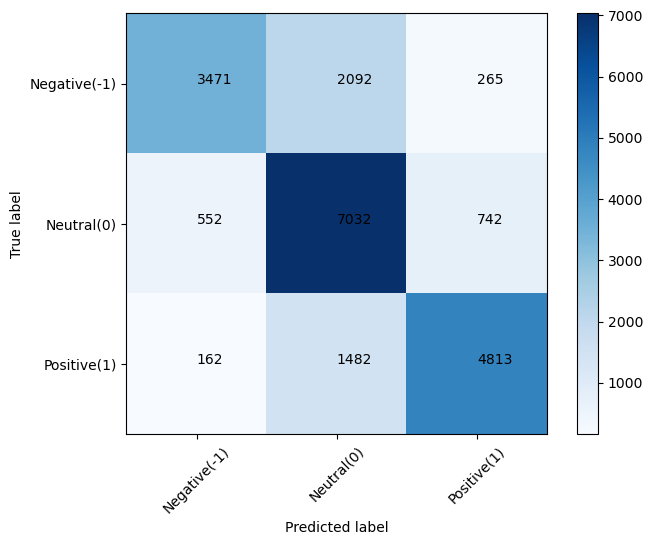

In [63]:
#Using  xGBoost (ExtremeGradientBoost)  Classifier to model the data
import xgboost as xgb

xgbc = xgb.XGBClassifier(random_state=0)
param_grid = {}
''' 
              'gamma': [0,0.1, 200],
              'learning_rate': [0.01,  0.3],
              'max_depth': [5],
              'n_estimators': [50],
              'reg_alpha': [0,0.1],
              'reg_lambda': [0,0.1]}
'''
xgbc_model = GridSearchCV(xgbc, param_grid = param_grid, cv = 2, verbose = True)
best_xgbc = xgbc_model.fit(X_train_dtm, y_train_xGBoost)
print('xGBoost Classifier', "\n", 
                "BestScore: ", best_xgbc.best_score_, '\n',
                 "Best parameters: ", best_xgbc.best_params_ )


#Print confusion matrix
y_predict_xgbc = xgbc_model.predict(X_train_dtm)
EvaluateModelxGBoost(y_train_xGBoost, y_predict_xgbc) 

#Model predictions
y_test_predict_xgbc = xgbc_model.predict(X_test_dtm)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
              precision    recall  f1-score   support

           0       1.00      0.44      0.61      8326
           1       0.83      0.56      0.67      6457
           2       0.46      1.00      0.63      5828

    accuracy                           0.64     20611
   macro avg       0.76      0.67      0.64     20611
weighted avg       0.80      0.64      0.64     20611

[[5823    0    5]
 [3920 3672  734]
 [2831    0 3626]]


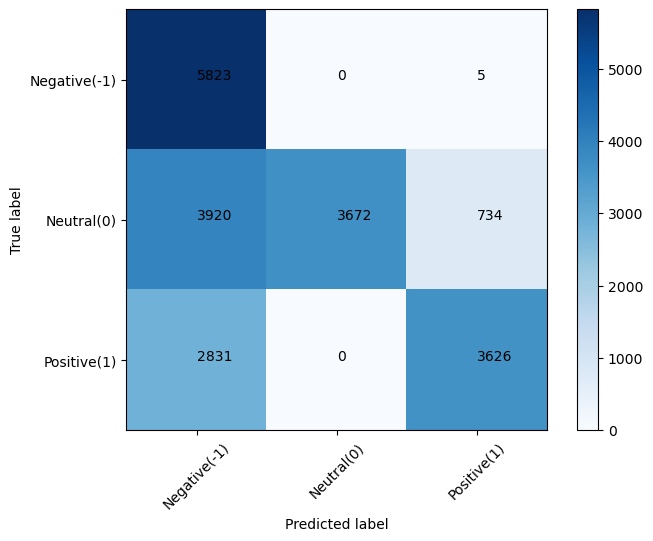

In [64]:
#Use GaussianNB to train the data set
#Use GaussianNB to train the data set
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputRegressor

nb = GaussianNB();
param_grid = {}
nb_model = GridSearchCV(nb, param_grid = param_grid, cv = 2, verbose = True, n_jobs = -1)
best_nb = nb_model.fit(X_train_dtm.toarray(), y_train_xGBoost)
#print('CountVectorize method for NLP using NaiveBayes', "\n", 
#                "BestScore: ", best_nb.best_score_, '\n',
#                 "Best parameters: ", best_nb.best_params_ )

#Print confusion matrix
y_predict_nb = nb_model.predict(X_train_dtm.toarray())
EvaluateModelxGBoost(y_train_xGBoost, y_predict_nb) 

#Model predictions
y_test_predict_nb = nb_model.predict(X_test_dtm.toarray())

In [65]:
Model =[lr_model, dct_model, rfc_model, svc_model, xgbc_model, nb_model]

accuracy_lr  = (y_train == y_predict_lr).mean()
accuracy_dct = (y_train == y_predict_dct).mean()
accuracy_rfc = (y_train == y_predict_rfc).mean()
accuracy_svc = (y_train == y_predict_svc).mean()
accuracy_xgbc =(y_train_xGBoost == y_predict_xgbc).mean()
accuracy_nb  = (y_train_xGBoost == y_predict_nb).mean()

ModelAccuracy = [accuracy_lr, accuracy_dct, accuracy_rfc,
                 accuracy_svc, accuracy_xgbc, accuracy_nb ]

print(ModelAccuracy)
print((y_train == y_predict_dct).mean())
IndexMax = ModelAccuracy.index(max(ModelAccuracy))
print(max(ModelAccuracy), Model[IndexMax])

#Save model to disk
filename = '../eval/finalmodel.pickle'
pickle.dump(Model[IndexMax], open(filename, 'wb'))

[0.8559507059337247, 0.997088933093979, 0.9970404153122119, 0.8972393382174567, 0.7430983455436417, 0.6366018145650381]
0.997088933093979
0.997088933093979 GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1, param_grid={},
             verbose=True)


### Decision tree and random forest gives an accuracy of 99% or aboove.

In [76]:
#Testing the model on random text

# load model
filename = '../eval/finalmodel.pickle'
loaded_model = pickle.load(open(filename, 'rb'))

CVect = pickle.load(open('../preprocess/CountVectorizer.pickle', 'rb' ))
#MyTwitterMessage='Good reasons the powerful good guys dont fight the powerful bad guys'
MyTwitterMessage='not careful'
sms = [text_process(MyTwitterMessage)]
print(sms)
x_sms = CVect.transform(sms)

ans = loaded_model.predict(x_sms)
print(ans)
if ans ==-1:
    print('The message is Negative')
if ans == 0:
    print('The message is Neutral')
if ans == 1:
    print('The message is Positive')

['not care ']
[0]
The message is Neutral
